# 12 - 双重稳健估计

## 别把所有鸡蛋放在同一个篮子里

我们已经学习了如何使用线性回归和倾向得分加权来估计 $E[Y|T=1] - E[Y|T=0] | X$。但应该选择哪一种方法，何时使用呢？当不确定时，不妨两者并用！双重稳健估计是一种将倾向得分与线性回归结合的方法，使你不必完全依赖其中任何一种。

为了理解这一方法如何运作，让我们以思维模式实验为例。这是一项在美国公立高中进行的随机研究，旨在探究成长型思维模式的影响。具体操作是学校为学生提供研讨会，以培养其成长型思维，随后在大学阶段跟踪调查学生的学业表现。这些测量结果被汇总成标准化后的成就分数。出于保护学生隐私的考虑，该研究的真实数据未公开。不过，我们使用了 [Athey 和 Wager](https://arxiv.org/pdf/1902.07409.pdf) 提供的具有相同统计特性的模拟数据集作为替代。

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [5]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


尽管该研究采用了随机化设计，但数据似乎仍无法完全避免混杂因素的影响。一个可能的原因是处理变量由学生是否参加研讨会来衡量。因此，虽然参与机会是随机的，但实际参与行为并非如此。我们在此面临的是一个不依从性问题。其中一个证据是学生的成功预期与参与研讨会之间存在相关性。自我报告有较高期望的学生更有可能参加了成长心态研讨会。

In [8]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

截至目前我们已了解，可以通过线性回归或使用逻辑回归估计倾向得分模型来对此进行调整。但在进行这些操作之前，我们需要将分类变量转换为虚拟变量。

In [11]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


我们现在已经准备好理解双重稳健估计是如何工作的了。

## 双重稳健估计

![img](./images/12/double.png)

与其推导估计量，我将先展示给你看，然后再告诉你它为何如此出色。

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

其中 $\hat{P}(x)$ 是倾向得分的估计（例如使用逻辑回归），$\hat{\mu_1}(x)$ 是 $E[Y|X, T=1]$ 的估计（例如使用线性回归），而 $\hat{\mu_0}(x)$ 是 $E[Y|X, T=0]$ 的估计。正如你可能已经猜到的，双重稳健估计的第一部分估计 $E[Y_1]$，第二部分估计 $E[Y_0]$。让我们先考察第一部分，因为所有直觉同样可以通过类比应用于第二部分。

既然我知道这个公式初看之下令人畏惧（但别担心，你会发现它其实非常简单），我将首先展示如何编写这个估计器的代码。我感觉有些人面对代码时的恐惧感比面对公式要少。让我们看看这个估计器在实践中是如何运作的，好吗？

In [15]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [17]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.3881646450560001

双重稳健估计量表明，就成就而言，我们应预期参加心态研讨会的个体比未接受处理的同伴高出 0.388 个标准差。再次强调，我们可以利用自助法构建置信区间。

In [23]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [24]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.35373750674610094, 0.4198590986953451)


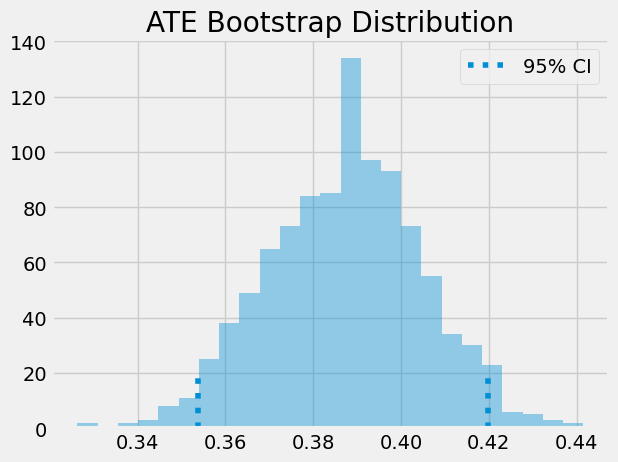

In [32]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend()
plt.show() ;

既然我们已经初步了解了双重稳健估计量，接下来让我们探讨其卓越之处。首先，它之所以被称为双重稳健，是因为只需模型 $\hat{P}(x)$ 或 $\hat{\mu}(x)$其中之一被正确设定即可。为了理解这一点，我们来看估计 $E[Y_1]$ 的第一部分，并仔细分析它。

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

假设 $\hat{\mu_1}(x)$ 是正确的。如果倾向得分模型有误，我们无需担忧。因为若 $\hat{\mu_1}(x)$ 正确，那么 $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$。这是由于乘以 $T_i$ 仅筛选出处理组，而根据定义，$\hat{\mu_1}$ 在处理组上的残差均值为零。这导致整个表达式简化为 $\hat{\mu_1}(X_i)$ ，根据假设，$E[Y_1]$ 的估计是正确的。因此，您看，$\hat{\mu_1}(X_i)$ 的正确性消除了倾向得分模型的相关性。我们可以运用相同的逻辑来理解 $E[Y_0]$ 的估计量。

但别只听我的一面之词。让代码为你指明方向！在接下来的估计器中，我将用于估算倾向得分的逻辑回归替换为一个从 0.1 到 0.9 的随机均匀变量（我不希望极小的权重导致倾向得分方差激增）。由于这一变量是随机的，它绝不可能成为一个优质的倾向得分模型，但我们将会看到，双重稳健估计器仍能生成与使用逻辑回归估算倾向得分时极为接近的估计结果。

In [35]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [37]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.37975320563665604

如果我们使用自助法（bootstrap），可以看到方差比用逻辑回归估计倾向得分时略高。

In [40]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [41]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.35373750674610094, 0.4198590986953451)
Wrong PS ATE 95% CI: (0.3371760135667188, 0.43335106915504895)


正如我们所见，搞砸倾向得分会导致略有不同的平均处理效应（ATE），但差异不大。这涵盖了倾向模型错误但结果模型正确的情况。那么另一种情形又如何呢？让我们再次仔细审视估计量的第一部分，不过这次让我们重新排列一些项。

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

现在，假设倾向得分 $\hat{P}(X_i)$ 被正确设定。在这种情况下，$E[T_i - \hat{P}(X_i)]=0$ 消除了依赖于 $\hat{\mu_1}(X_i)$ 的部分。这使得双重稳健估计量简化为倾向得分加权估计量 $\frac{T_iY_i}{\hat{P}(X_i)}$，根据假设这是正确的。因此，即使 $\hat{\mu_1}(X_i)$ 是错误的，只要倾向得分设定正确，估计量仍将保持正确。

如果你更相信代码而非公式，那么这里提供了实际的验证。在下面的代码中，我将两个回归模型都替换为一个随机正态变量。毫无疑问，$\hat{\mu}(X_i)$ 并**未正确设定**。尽管如此，我们将看到双重稳健估计仍能恢复之前所见的大约 0.38 的 $\hat{ATE}$。

In [50]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [52]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.398469826238579

我们可以再次使用自助法（bootstrap），发现方差只是略高一些。

In [55]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [56]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(wrong_mux, 97.5)))

Original ATE 95% CI: (0.35373750674610094, 0.4198590986953451)
Wrong Mu ATE 95% CI: (0.33863565118418126, 0.433032068728169)


再次，仅对条件均值模型进行干扰，所得的平均处理效应(ATE)差异微乎其微。我希望我已让你信服双重稳健估计的强大之处。其神奇效果源于因果推断中消除估计偏误的两种途径：要么建模处理机制，要么建模结果机制。只要其中任一模型正确，便能确保估计的有效性。

有一点需要注意的是，在实践中，精确建模这两者中的任何一个都非常困难。更常见的情况是，倾向得分和结果模型都不完全正确。它们都存在错误，但错误的方式不同。当这种情况发生时，究竟是使用单一模型还是双重稳健估计更为优越，目前尚未有定论[\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/)。就我个人而言，我仍然倾向于使用它们，因为这至少提供了两种可能正确的途径。

## 核心要点

在此，我们介绍了一种将线性回归与倾向得分相结合以生成双重稳健估计量的简便方法。该估计量之所以得名，是因为它仅需其中一个模型正确即可发挥作用。若倾向得分模型正确，即便结果模型有误，我们仍能识别因果效应；反之，若结果模型正确，即使倾向得分模型存在偏误，因果效应的识别同样可行。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。